In [1]:
# =================================================
# Install essential packages for CIFAR-10 projects
# in the current PyTorch kernel
# =================================================

import sys
import subprocess

def install(package):
    """Install a package in the current Python environment."""
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

# Packages needed for CIFAR-10 projects
packages = [
    "torch",          # PyTorch
    "torchvision",    # Datasets and transforms
    "scikit-learn",   # ML algorithms (KMeans, train_test_split, etc.)
    "numpy",          # Numerical operations
    "matplotlib",     # Plotting images and graphs
    "pandas",         # Optional: data handling
]

for pkg in packages:
    install(pkg)

# Verify installation
import torch
import torchvision
import sklearn
import numpy as np
import matplotlib.pyplot as plt

print('done')
#don't rerun

done


In [2]:
# ==========================================
# 1. IMPORT LIBRARIES
# ==========================================
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import models

import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score
from scipy.stats import mode


In [3]:
BATCH_SIZE = 256
NUM_CLASSES = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

Using device: cpu


In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset  = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=False)
testloader  = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)

# Get labels for evaluation
train_labels = np.array([label for _, label in trainset])
test_labels = np.array([label for _, label in testset])

Files already downloaded and verified
Files already downloaded and verified


In [5]:
# ==========================================
# 4. FEATURE EXTRACTION FOR K-MEANS
# Using pretrained ResNet-18 as a feature extractor
# ==========================================

NUM_CLASSES = 10


resnet18 = models.resnet18(pretrained=True)
resnet18 = resnet18.to(DEVICE)
resnet18.eval()



def extract_features(dataloader):
    all_features = []
    with torch.no_grad():
        for images, _ in dataloader:
            images = images.to(DEVICE)
            feats = feature_extractor(images)
            feats = feats.view(feats.size(0), -1)  # flatten
            all_features.append(feats.cpu().numpy())
    return np.vstack(all_features)

print("Extracting train features...")



C:\Users\gecon\miniconda3\envs\torch312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\gecon\miniconda3\envs\torch312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Extracting train features...


In [34]:
layers = list(resnet18.children())
print(len(layers))
print(layers)

10
[Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False), BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), ReLU(inplace=True), MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False), Sequential(
  (0): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (1): BasicBlock(
    (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), 

In [9]:



for remove_n in range(1, len(layers)):  
    keep_layers = layers[:-remove_n]

    print(f"\n==============================")
    print(f"Layers 0 to {len(keep_layers)-1}")
    print("==============================")

    feature_extractor = nn.Sequential(*keep_layers).to(DEVICE)
    feature_extractor.eval()

    # Extract features
    print("Extracting features...")
    train_features = extract_features(trainloader)
    test_features = extract_features(testloader)

    print("Train features shape:", train_features.shape)
    print("Test features shape:", test_features.shape)

    # ---- K-Means ----
    kmeans = KMeans(n_clusters=NUM_CLASSES, random_state=42, n_init=10)
    kmeans.fit(train_features)

    train_clusters = kmeans.predict(train_features)
    test_clusters  = kmeans.predict(test_features)

    # True labels
    train_true_labels = np.array([label for _, label in trainset])
    test_true_labels  = np.array([label for _, label in testset])

    # Map clusters → labels
    cluster_to_label = {}
    for cid in range(NUM_CLASSES):
        cluster_labels = train_true_labels[train_clusters == cid]
        if len(cluster_labels) == 0:
            cluster_to_label[cid] = -1
        else:
            cluster_to_label[cid] = np.bincount(cluster_labels).argmax()

    train_pred = np.array([cluster_to_label[c] for c in train_clusters])
    test_pred  = np.array([cluster_to_label[c] for c in test_clusters])

    test_acc = accuracy_score(test_true_labels, test_pred)

    print(f"K-Means Test Accuracy after removing last {remove_n} layer(s): {test_acc:.4f}")




Layers 0 to 8
Extracting features...
Train features shape: (50000, 512)
Test features shape: (10000, 512)
K-Means Test Accuracy after removing last 1 layer(s): 0.2567

Layers 0 to 7
Extracting features...
Train features shape: (50000, 512)
Test features shape: (10000, 512)
K-Means Test Accuracy after removing last 2 layer(s): 0.2567

Layers 0 to 6
Extracting features...
Train features shape: (50000, 1024)
Test features shape: (10000, 1024)
K-Means Test Accuracy after removing last 3 layer(s): 0.2774

Layers 0 to 5
Extracting features...
Train features shape: (50000, 2048)
Test features shape: (10000, 2048)
K-Means Test Accuracy after removing last 4 layer(s): 0.3130

Layers 0 to 4
Extracting features...
Train features shape: (50000, 4096)
Test features shape: (10000, 4096)
K-Means Test Accuracy after removing last 5 layer(s): 0.3292

Layers 0 to 3
Extracting features...
Train features shape: (50000, 4096)
Test features shape: (10000, 4096)
K-Means Test Accuracy after removing last 6 l

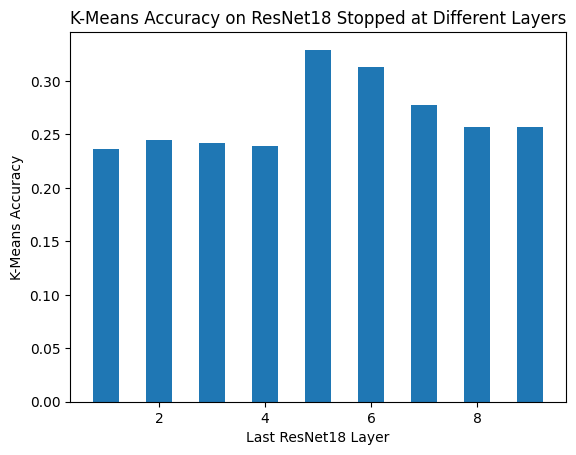

In [23]:
import matplotlib.pyplot as plt
x = [9, 8, 7, 6, 5, 4, 3, 2, 1]
y = [0.2567, 0.2567, 0.2774,  0.3130,0.3292,0.2393,0.2419,0.2446,0.2364]
plt.title('K-Means Accuracy on ResNet18 Stopped at Different Layers')
plt.xlabel('Last ResNet18 Layer')
plt.ylabel('K-Means Accuracy')
plt.bar(x, y, width=0.5)
plt.show()

In [26]:
print(np.std([0.2567, 0.2567, 0.2774,  0.3130,0.3292,0.2393,0.2419,0.2446,0.2364]))

0.03185704178217291
